In [1]:
# pip install -r requirements.txt -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html


# Results

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from src.augmentations import AugsCreation
from src.baseline_config import TaskConfig
from src.baseline_model import CRNN
from src.collator import Collator
from src.dataset import SpeechCommandDataset
from src.dkd_config import DistillationTaskConfig
from src.logmelspec import LogMelspec
from src.trainers import train_epoch, train_epoch_distillation, validation
from src.utils import get_sampler, count_FA_FR, get_au_fa_fr

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 13:59:41--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   155MB/s    in 9.8s    

2021-11-22 13:59:51 (146 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

torch.manual_seed(42)
use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.cuda.manual_seed_all(42)

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

## Distillation results

Создал 2 модели с помощью дистилляции:
1.   Отличается от базовой модели уменьшенным количеством выходных каналов в свертке (8 -> 4) и уменьшенным hidden_size у gru (64 -> 16)
2.   По результатам первой было понятно, что можно уменьшить еще сильнее, но уже за счет уменьшения числа слоев gru (2 -> 1). Если оставить hidden_size 16, то модель просто будет плохой, поэтому увеличим его в 2 раза (16 -> 32), а число выходных каналов в свертке вообще можно сделать равным 1. За счет таких изменений можно также ускорить модель.




In [6]:
teacher= {'config': TaskConfig(), 'c_config': TaskConfig(device='cpu'), 'weights': 'saved/teacher_model.pth'}
dkd_4_16 = {'config': DistillationTaskConfig(batch_size=64, cnn_out_channels=4, kernel_size=(5, 20), stride=(2, 8), num_epochs=30, temperature=4, alpha=0.5), 'c_config': DistillationTaskConfig(batch_size=64, cnn_out_channels=4, kernel_size=(5, 20), stride=(2, 8), num_epochs=30, temperature=4, alpha=0.5, device='cpu'),'weights': 'saved/student_dkd_4_16_model.pth'}
dkd_1_32_1 = {'config': DistillationTaskConfig(batch_size=64, cnn_out_channels=1, hidden_size=32, kernel_size=(5, 20), stride=(2, 8), num_epochs=20, gru_num_layers=1, temperature=5, alpha=0.2), 'c_config': DistillationTaskConfig(batch_size=64, cnn_out_channels=1, hidden_size=32, kernel_size=(5, 20), stride=(2, 8), num_epochs=20, gru_num_layers=1, temperature=5, alpha=0.2, device='cpu'), 'weights': 'saved/student_model_dkd_1_32_1.pth'}

In [7]:
for model in (teacher, dkd_4_16, dkd_1_32_1):
    model['model'] = CRNN(model['config'])
    model['model'].load_state_dict(torch.load(model['weights']))
    model['model'].to(model['config'].device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [8]:
teacher['name'] = 'teacher'
dkd_4_16['name'] = 'dkd_4_16'
dkd_1_32_1['name'] = 'dk_1_32_1'

`print_size_of_model` - функция из документации torch для правильного подсчета размера модели 

In [9]:
import os
import thop

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [10]:
for model in (teacher, dkd_4_16, dkd_1_32_1):
    torch.manual_seed(42)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        torch.cuda.manual_seed_all(42)

    val_loader = DataLoader(val_set, batch_size=model['config'].batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)
    
    distill_melspec_val = LogMelspec(is_train=False, config=model['config'])
    
    au_fa_fr = validation(model['model'], val_loader,
                          distill_melspec_val, model['config'].device)
    
    model['au_fa_fr'] = au_fa_fr
    model['size'] = print_size_of_model(model['model'], model['name'])
    model['macs'], _ = thop.profile(model['model'], (torch.randn(128, 40, 101).to(model['config'].device), ), verbose=False)
    print(model['name'], 'au_fa_fr:', au_fa_fr, 'size:', model['size'], 'macs:', model['macs'])

102it [00:05, 18.43it/s]


model:  teacher  	 Size (KB): 285.195
teacher au_fa_fr: 2.4126794870475127e-05 size: 285195 macs: 119527424.0


203it [00:05, 38.92it/s]


model:  dkd_4_16  	 Size (KB): 30.155
dkd_4_16 au_fa_fr: 3.427162575838206e-05 size: 30155 macs: 19321856.0


203it [00:05, 38.97it/s]


model:  dk_1_32_1  	 Size (KB): 28.171
dk_1_32_1 au_fa_fr: 3.40925993309484e-05 size: 28171 macs: 11398912.0


In [11]:
for model in (dkd_4_16, dkd_1_32_1):
    print(model['name'], 'compression rate:', teacher['size'] / model['size'], 'speed up rate:', teacher['macs'] / model['macs'])

dkd_4_16 compression rate: 9.45763554966009 speed up rate: 6.186125390852721
dk_1_32_1 compression rate: 10.123708778531114 speed up rate: 10.485862510386957


Как видно, вторая конфигурация позволила сделать compression_rate и speed_up_rate большими 10. Если посмотреть в ноутбук с тренировкой, то можно заметить, что при старом подсчете веса модели (основаном на количестве весов), первая конфигурация также давала улучшение по памяти в 10 раз (~70000 -> ~6700 параметров), но недостаточно ускоряла модель.

Значения метрики в допустимых пределах - все они меньше 5e-5

Маки считал просто пропуская через модель батч размера 128 как при обучении/валидации, поэтому MACs принимает такие большие значения, но размер батча не влияет на отношение МАКов между моделями (MAC(batch_128) = 128*MAC(batch_1))

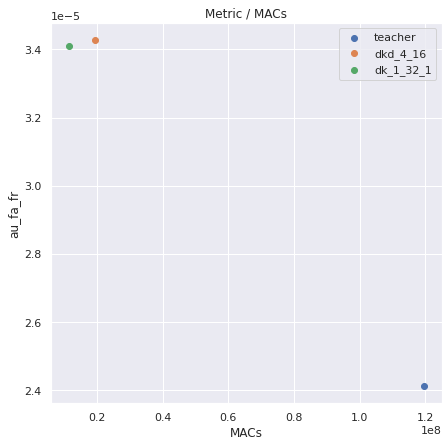

In [13]:
plt.figure(figsize=(7, 7))
for model in (teacher, dkd_4_16, dkd_1_32_1):
    plt.scatter([model['macs']], [model['au_fa_fr']], label = model['name'])
plt.legend()
plt.xlabel('MACs')
plt.ylabel('au_fa_fr')
plt.title('Metric / MACs')
plt.show()

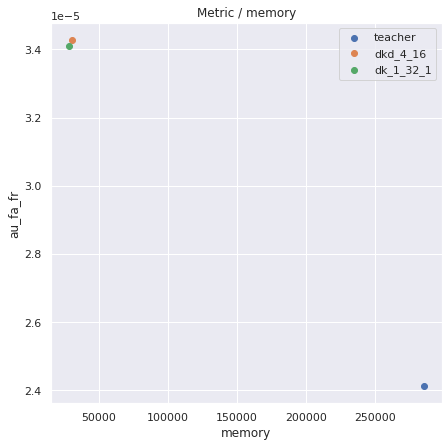

In [14]:
plt.figure(figsize=(7, 7))
for model in (teacher, dkd_4_16, dkd_1_32_1):
    plt.scatter([model['size']], [model['au_fa_fr']], label = model['name'])
plt.legend()
plt.xlabel('memory')
plt.ylabel('au_fa_fr')
plt.title('Metric / memory')
plt.show()

Графики, как требуется в условии

## Quantization

Использовал qint8-динамическую квантизацию. Сразу скажу, что сравнения по производительности не проводилось в связи с невозможностью точно посчитать MACs для квантизированных слоев модели, поэтому считаем что после квантизации производительность не поменялась.

In [15]:
for model in (teacher, dkd_4_16, dkd_1_32_1):
    model['qint8'] = torch.quantization.quantize_dynamic(model['model'].to('cpu'), {nn.Linear, nn.GRU}, dtype=torch.qint8)
    torch.manual_seed(42)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        torch.cuda.manual_seed_all(42)

    val_loader = DataLoader(val_set, batch_size=model['config'].batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)
    
    distill_melspec_val = LogMelspec(is_train=False, config=model['c_config'])

    au_fa_fr = validation(model['qint8'], val_loader,
                          distill_melspec_val, 'cpu')
    
    model['q_au_fa_fr'] = au_fa_fr
    model['q_size'] = print_size_of_model(model['qint8'], model['name'])
    print(model['name'], 'au_fa_fr:', au_fa_fr, 'size:', model['q_size'])

102it [00:09, 10.76it/s]


model:  teacher  	 Size (KB): 86.591
teacher au_fa_fr: 2.4908543603602073e-05 size: 86591


203it [00:08, 22.87it/s]


model:  dkd_4_16  	 Size (KB): 19.711
dkd_4_16 au_fa_fr: 3.58231881294737e-05 size: 19711


/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/dynamic/modules/rnn.py:64: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
203it [00:08, 23.23it/s]


model:  dk_1_32_1  	 Size (KB): 16.907
dk_1_32_1 au_fa_fr: 3.355552004864745e-05 size: 16907


In [16]:
for model in (teacher, dkd_4_16, dkd_1_32_1):
    print(model['name'], 'self compression rate:', model['size'] / model['q_size'])

teacher self compression rate: 3.2935870933468836
dkd_4_16 self compression rate: 1.5298564253462534
dk_1_32_1 self compression rate: 1.6662329212752114


In [17]:
for model in (teacher, dkd_4_16, dkd_1_32_1):
    print(model['name'], 'compression rate:', teacher['size'] / model['q_size'])

teacher compression rate: 3.2935870933468836
dkd_4_16 compression rate: 14.468824514230633
dk_1_32_1 compression rate: 16.8684568521914


Видим что для базовой модели квантизация подействовала сильнее чем на дистиллированные модели, но в общем раскладе получили что с помощью квантизации получилось добиться улучшения по памяти в 16.868 раз относительно базовой модели. Метрики при этом также остались меньше 5e-5, а для наименьшей модели квантизация вообще улучшила итоговую метрику.

График для сравнения ниже

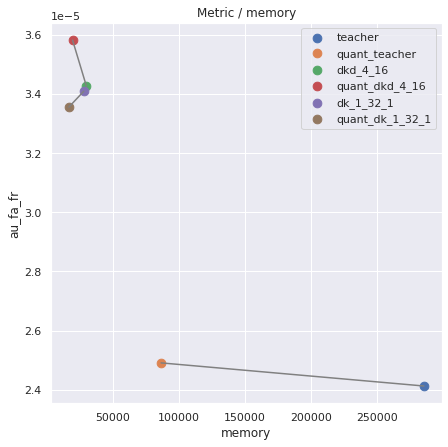

In [18]:
plt.figure(figsize=(7, 7))
for model in (teacher, dkd_4_16, dkd_1_32_1):
    plt.plot([model['size'], model['q_size']], [model['au_fa_fr'], model['q_au_fa_fr']], c='grey')
    plt.scatter([model['size']], [model['au_fa_fr']], label = model['name'], s=75)
    plt.scatter([model['q_size']], [model['q_au_fa_fr']], label = 'quant_'+model['name'], s=75)
plt.legend()
plt.xlabel('memory')
plt.ylabel('au_fa_fr')
plt.title('Metric / memory')
plt.show()

## Streaming

Реализовал стриминг, за основу которого была взята базовая модель. Переписан forward для валидации модели - при тренировке он точно такой же как и раньше.

`streaming_step_size` можно было сделать параметром модели, но тогда бы он заменял собой `config.stride[1]`, так как только в таком случае будет оптимальное количество сверток, поэтому я решил не делать его параметром и считать, что он равен `config.stride[1]`.

In [21]:
from src.streaming import StreamingCRNN

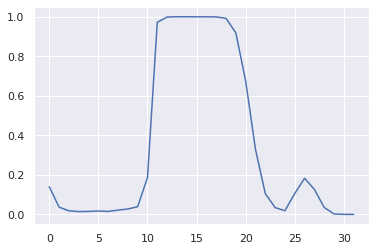

In [28]:
stream = StreamingCRNN(50, TaskConfig).to('cuda')
stream.load_state_dict(torch.load('saved/teacher_model.pth'))

dataset.csv[dataset.csv['label'] == 1].sample(1)['path'].item()
kw = dataset.csv[dataset.csv['label'] == 1].sample(1)['path'].item()
not_kw = list(dataset.csv[dataset.csv['label'] == 0].sample(2)['path'])

x = torch.cat([torchaudio.load(path)[0].squeeze() for path in (not_kw[0], kw, not_kw[1])])
x = x.to('cuda')

val_melspec = LogMelspec(is_train=False, config=TaskConfig)
x = val_melspec(x)

stream.eval()
res = stream(x)
all = []
for elem in res:
    tmp = F.softmax(elem, dim=-1).tolist()
    for k in tmp:
        all.append(k[1])
plt.plot(all)

Поместил трек с keyword'ом между двумя случайными треками без него, получил вполне логичный результат - модель к середине итоговой дорожки дает предсказание keyword'а с вероятностью 1, а до и после ближе к 0, т.к. сначала не знает о существовании части с keyword'ом, а потом "забывает" об этом.

# Итог

In [30]:
print(dkd_1_32_1['name'], 'compression rate:', teacher['size'] / dkd_1_32_1['q_size'], 'speed up rate:', teacher['macs'] / model['macs'])

dk_1_32_1 compression rate: 16.8684568521914 speed up rate: 10.485862510386957


Есть Стриминг, а также 3 конфигурации: дистилляция (2 вида), квантизация qint8 и квантизация qint8 над дистилляциями